Après avoir effectué un nettoyage approfondi des données et identifié les variables prédictives disponibles avant l'accouchement (lors de l'admission en salle de naissance), nous allons explorer différents modèles de classification en commençant par la régression logistique, qui offre une bonne interprétabilité. Notre variable cible binaire, hpp_trans (Hémorragie post-partum nécessitant une transfusion), présente un fort déséquilibre avec seulement 0.78% de cas positifs. Pour permettre au modèle de détecter efficacement le signal dans ces données déséquilibrées, nous allons tester plusieurs techniques de rééquilibrage.

Notre approche sera progressive :
1. Évaluation du modèle de base sans rééquilibrage
2. Test de différentes techniques de rééquilibrage (sur-échantillonnage, sous-échantillonnage et pondération des classes)
3. Optimisation des hyperparamètres via GridSearch en considérant le score F1 et le recall
 
Dans ce contexte médical où une mauvaise classification peut avoir des conséquences graves, nous privilégierons l'optimisation du recall tout en maintenant une précision acceptable. Les performances seront évaluées entre autres à l'aide des courbes ROC et precision-recall. Bien que le seuil de décision soit initialement fixé à 0.5, nous explorerons différents seuils pour optimiser les résultats.

In [2]:
# Bibliothèques standards
import logging
import os

# Bibliothèques de données et calcul scientifique
import joblib
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# MLflow
import mlflow
import mlflow.data.pandas_dataset
import mlflow.sklearn

# Scikit-learn - Prétraitement
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

# Scikit-learn - Modélisation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                   StratifiedKFold, train_test_split)
from sklearn.pipeline import Pipeline

# Scikit-learn - Métriques
from sklearn.metrics import (ConfusionMatrixDisplay, auc, classification_report,
                           f1_score, make_scorer, precision_recall_curve,
                           precision_score, recall_score, roc_auc_score,
                           roc_curve)

# Imbalanced-learn
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# XGBoost
from xgboost import XGBClassifier

In [3]:
df_dico = pd.read_csv('Project/clean/description_variable_clean.csv',index_col=0)
df_model = pd.read_csv('Project/clean/Bourgogne20132023_clean.csv', index_col=0)

In [4]:
# Fonction pour mettre à jour les listes de features en fonction du dictionnaire de variables
def update_list_features(X_train, df_dico):
    df_dico = df_dico.reindex(X_train.columns)
    quant_features = df_dico[df_dico['type_var'] == 'Quantitative'].index.tolist()
    binary_features = df_dico[df_dico['type_var'] == 'Binaire'].index.tolist()
    nominal_features = df_dico[df_dico['type_var'] == 'Nominale'].index.tolist()
    ordinal_features = df_dico[df_dico['type_var'] == 'Ordinale'].index.tolist()
    return quant_features, binary_features, nominal_features, ordinal_features

In [5]:
df_dico

,count,value_counts,nunique,min,max,description,type_var
bmi,53061,NaN,359,12.0,50.0,"L'indice de masse corporelle (IMC, ou BMI en a...",Quantitative
terme,65534,NaN,172,22.0,43.0,Terme à l'accouchement en semaine d aménorrhée...,Quantitative
dsm_g,65494,NaN,88,0.0,102.0,Duree hosp. pendant la grossesse,Quantitative
taille_mere,53227,NaN,55,109.0,190.0,Taille de la mére (en cm),Quantitative
age_m,65534,NaN,42,12.0,62.0,Age maternel calculé à partir de la date de na...,Quantitative
parite,54213,NaN,14,0.0,23.0,Parité obstétricale : nombre d'enfants issues ...,Quantitative
nbilan,65534,NaN,12,0.0,16.0,Nb bilans au cours de la grossesse,Quantitative
hosp_m_g,65534,NaN,10,0.0,9.0,Hosp. pendant la grossesse (0 : Non/1 : Oui),Quantitative
nsej18,65534,"{0: 61524, 1: 3477, 2: 416, 3: 88, 4: 20, 5: 7...",8,0.0,8.0,Nb sejours < 18 SA,Quantitative
AMP,65534,"{'Aucune': 64379, 'FIV': 353, 'FIV ICSI': 229,...",6,NaN,NaN,"Aide médicale à la procréation (FIV, ICSI, TEC...",Nominale


In [6]:
df_model=df_model.dropna()

X=df_model.drop(['hpp_trans'],axis=1)
y=df_model["hpp_trans"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

quant_features, binary_features, nominal_features, ordinal_features = update_list_features(X_train, df_dico)

print('Nombre de lignes et de colonnes de X_train : ',X_train.shape,'\n')


print(X_train[:5])

print("Quantitative features : ",quant_features)
print("Binaire features : ",binary_features)
print("Nominal features : ",nominal_features)
print("Ordinale features : ",ordinal_features)



Nombre de lignes et de colonnes de X_train :  (42350, 22) 

       age_m  taille_mere   bmi  tabac  parite  diabete  hta_tot  cholestase  \
45967   36.0        160.0  30.9      0     9.0        0        0           0   
1953    24.0        164.0  21.9      0     0.0        0        0           0   
9096    32.0        160.0  25.4      0     1.0        0        0           0   
43484   37.0        163.0  18.8      0     2.0        0        0           0   
44651   35.0        161.0  32.8      0     1.0        0        0           0   

       preecl  hellp  ...  ut_cica  cortico     AMP  pma hosp_m_g  dsm_g  \
45967       0      0  ...        1        0  Aucune    0        0    0.0   
1953        0      0  ...        0        0  Aucune    0        0    0.0   
9096        0      0  ...        1        0  Aucune    0        0    0.0   
43484       0      0  ...        0        1  Aucune    0        1    4.0   
44651       0      0  ...        0        0  Aucune    0        0    0.0   

  

In [69]:
# Création des transformateurs pour chaque type de variable

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first',handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Création du preprocesseur avec ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, quant_features),
        ("bin", "passthrough", binary_features), 
        ('nom', nominal_transformer, nominal_features),
        ('ord', ordinal_transformer, ordinal_features)
    ])




In [82]:
def evaluate_model(model, X_train, X_test, y_train, y_test, experiment_name="Default", run_name="Default Run", use_mlflow=True):
    """
    Évalue un modèle entraîné et génère différents graphiques et métriques avec tracking MLflow optionnel
    """
    results = {}
    figures = []
    metrics = {}
    
    # Prédictions et probabilités
    y_prob_test = model.predict_proba(X_test)[:, 1]
    y_prob_train = model.predict_proba(X_train)[:, 1]
    
    # Prédictions avec seuil 0.5
    y_pred_test = (y_prob_test > 0.5).astype(int)
    y_pred_train = (y_prob_train > 0.5).astype(int)

    # Calcul des métriques de base
    metrics["recall_train"] = round(recall_score(y_train, y_pred_train), 4)
    metrics["precision_train"] = round(precision_score(y_train, y_pred_train), 4) 
    metrics["f1_train"] = round(f1_score(y_train, y_pred_train), 4)
    
    metrics["recall_test"] = round(recall_score(y_test, y_pred_test), 4)
    metrics["precision_test"] = round(precision_score(y_test, y_pred_test), 4)
    metrics["f1_test"] = round(f1_score(y_test, y_pred_test), 4)

    # Matrices de confusion
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, ax=ax)
    plt.title("Confusion Matrix - Train Set")
    figures.append(("01-confusion_matrix_train.png", fig))
    plt.show()

    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, ax=ax)
    plt.title("Confusion Matrix - Test Set")
    figures.append(("02-confusion_matrix_test.png", fig))
    plt.show()

    # Courbes ROC
    fpr, tpr, _ = roc_curve(y_train, y_prob_train)
    metrics["roc_auc_train"] = round(roc_auc_score(y_train, y_prob_train), 4)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label=f"ROC curve (AUC = {metrics['roc_auc_train']:.4f})")
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve - Train Set")
    ax.legend()
    figures.append(("03-roc_curve_train.png", fig))
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    metrics["roc_auc_test"] = round(roc_auc_score(y_test, y_prob_test), 4)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label=f"ROC curve (AUC = {metrics['roc_auc_test']:.4f})")
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve - Test Set")
    ax.legend()
    figures.append(("04-roc_curve_test.png", fig))
    plt.show()

    # Courbes Precision-Recall
    train_precision, train_recall, _ = precision_recall_curve(y_train, y_prob_train)
    metrics["pr_auc_train"] = round(auc(train_recall, train_precision), 4)
    fig, ax = plt.subplots()
    ax.plot(train_recall, train_precision, lw=2, label=f"PR curve (AUC = {metrics['pr_auc_train']:.4f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve - Train Set")
    ax.legend()
    ax.grid()
    figures.append(("05-precision_recall_curve_train.png", fig))
    plt.show()

    test_precision, test_recall, _ = precision_recall_curve(y_test, y_prob_test)
    metrics["pr_auc_test"] = round(auc(test_recall, test_precision), 4)
    fig, ax = plt.subplots()
    ax.plot(test_recall, test_precision, lw=2, label=f"PR curve (AUC = {metrics['pr_auc_test']:.4f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve - Test Set")
    ax.legend()
    ax.grid()
    figures.append(("06-precision_recall_curve_test.png", fig))
    plt.show()

    # Test de différents seuils
    seuils = np.arange(0.1, 1.0, 0.1)
    recalls_test = []
    precisions_test = []
    f1_scores_test = []

    for seuil in seuils:
        y_pred_test = (y_prob_test > seuil).astype(int)
        recall = round(recall_score(y_test, y_pred_test, zero_division=0), 4)
        precision = round(precision_score(y_test, y_pred_test, zero_division=0), 4)
        f1 = round(f1_score(y_test, y_pred_test, zero_division=0), 4)
        
        recalls_test.append(recall)
        precisions_test.append(precision)
        f1_scores_test.append(f1)
        
        metrics[f"recall_test_seuil_{seuil:.1f}"] = recall
        metrics[f"precision_test_seuil_{seuil:.1f}"] = precision
        metrics[f"f1_test_seuil_{seuil:.1f}"] = f1

    # Graphique seuils
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(seuils, recalls_test, label="Recall", marker="o")
    ax.plot(seuils, precisions_test, label="Precision", marker="o")
    ax.plot(seuils, f1_scores_test, label="F1-Score", marker="o")
    ax.set_xlabel("Seuil de décision")
    ax.set_ylabel("Métrique")
    ax.set_title("Évolution des métriques en fonction du seuil (Test Set)")
    ax.legend()
    ax.grid(True)
    figures.append(("07-threshold_search.png", fig))
    plt.show()

    # Feature Importance
    try:
        feature_names = model.named_steps["preprocessor"].get_feature_names_out()
    except AttributeError:
        feature_names = X_train.columns

    # Obtenir l'importance des features selon le type de modèle
    if hasattr(model.named_steps["classifier"], "coef_"):
        # Pour LogisticRegression
        importance = model.named_steps["classifier"].coef_[0]
        importance_type = "Coefficient"
    elif hasattr(model.named_steps["classifier"], "feature_importances_"):
        # Pour RandomForest et XGBoost
        importance = model.named_steps["classifier"].feature_importances_
        importance_type = "Importance"
    else:
        raise AttributeError("Le modèle ne supporte pas l'importance des features")

    feature_importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance,
        "Absolute_Importance": np.abs(importance),
    }).sort_values(by="Absolute_Importance", ascending=False)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(feature_importance_df["Feature"], feature_importance_df["Absolute_Importance"])
    ax.set_xlabel(f"Absolute {importance_type} Value")
    ax.set_ylabel("Feature")
    ax.set_title(f"Feature Importance - {model.named_steps['classifier'].__class__.__name__}")
    ax.invert_yaxis()
    plt.tight_layout()
    figures.append(("08-feature_importance.png", fig))
    plt.show()

    # Classification reports
    report_train = classification_report(y_train, y_pred_train, zero_division=0)
    report_test = classification_report(y_test, y_pred_test, zero_division=0)

    # Enregistrement dans MLflow si use_mlflow est True
    if use_mlflow:
        mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "https://thibautmodrin-mlflow.hf.space"))
        mlflow.set_experiment(experiment_name)
        mlflow.sklearn.autolog(disable=True)
        
        with mlflow.start_run(run_name=run_name):
            # Log des paramètres
            mlflow.log_params(model.get_params())

            # Log du modèle
            signature = mlflow.models.infer_signature(
                model.named_steps['preprocessor'].transform(X_train),
                model.predict(X_train)
            )
            mlflow.sklearn.log_model(model, model.__class__.__name__, signature=signature)
            
            # Log des datasets
            for col in X_train.select_dtypes(include=['int']).columns:
                X_train[col] = X_train[col].astype(float)
            y_train = y_train.astype(float)
            mlflow.log_input(mlflow.data.pandas_dataset.from_pandas(X_train, name="X_train"))
            mlflow.log_input(mlflow.data.pandas_dataset.from_pandas(pd.DataFrame(y_train), name="y_train"))
            
            # Log des métriques
            mlflow.log_metrics(metrics)
            
            # Log des figures
            for name, fig in figures:
                mlflow.log_figure(fig, name)
                
            # Log des rapports
            mlflow.log_text(report_train, "09-classification_report_train.txt")
            mlflow.log_text(report_test, "10-classification_report_test.txt")

    results['y_pred_train'] = y_pred_train
    results['y_pred_test'] = y_pred_test
    results['y_prob_train'] = y_prob_train
    results['y_prob_test'] = y_prob_test
    
    return results


### 1. Test du modèle de référence pour établir notre baseline

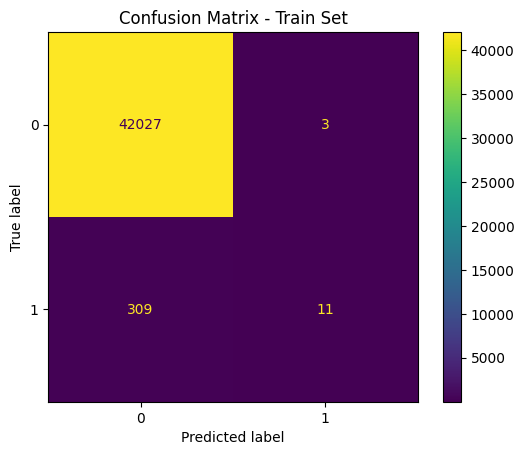

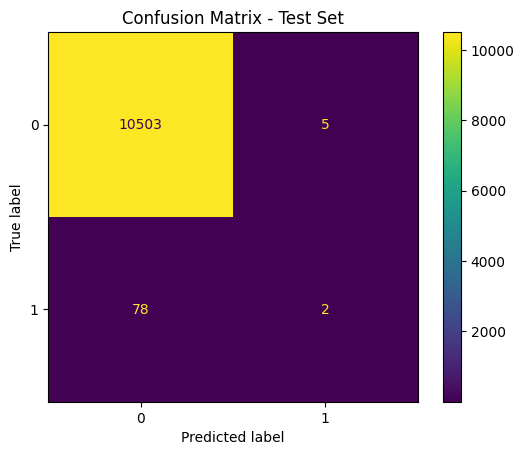

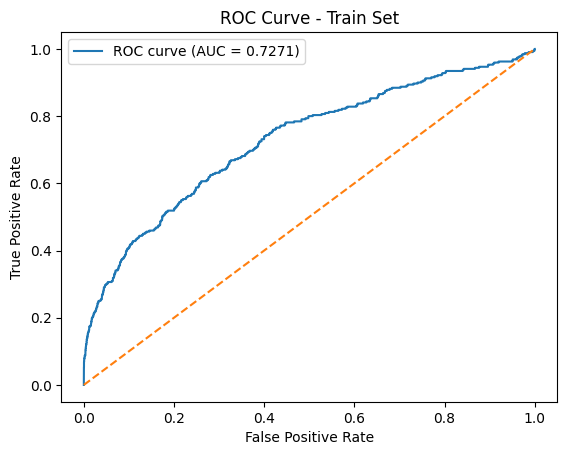

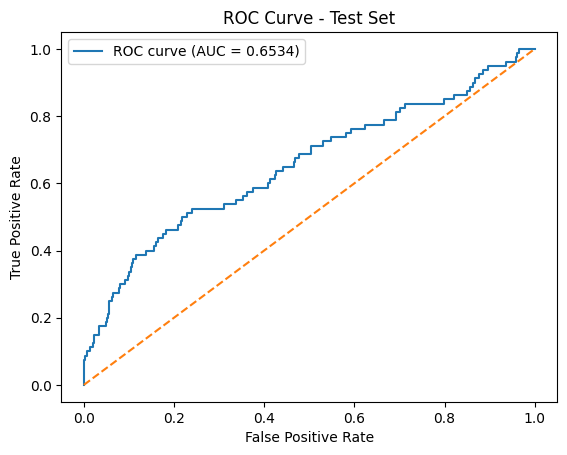

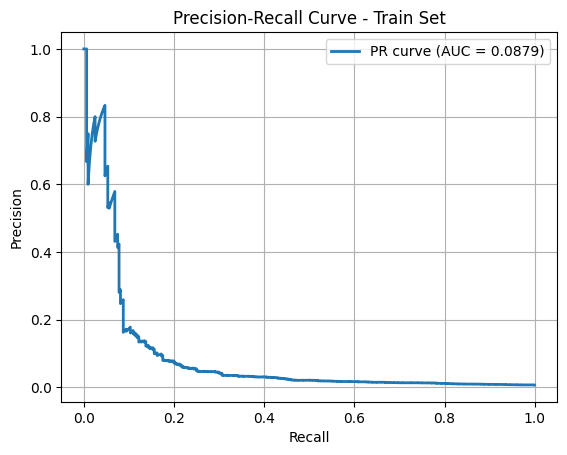

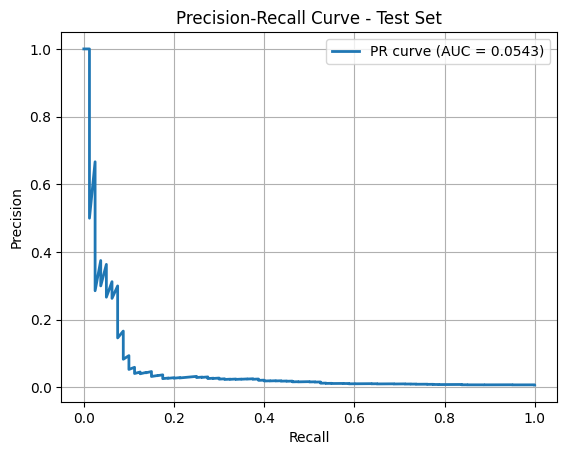

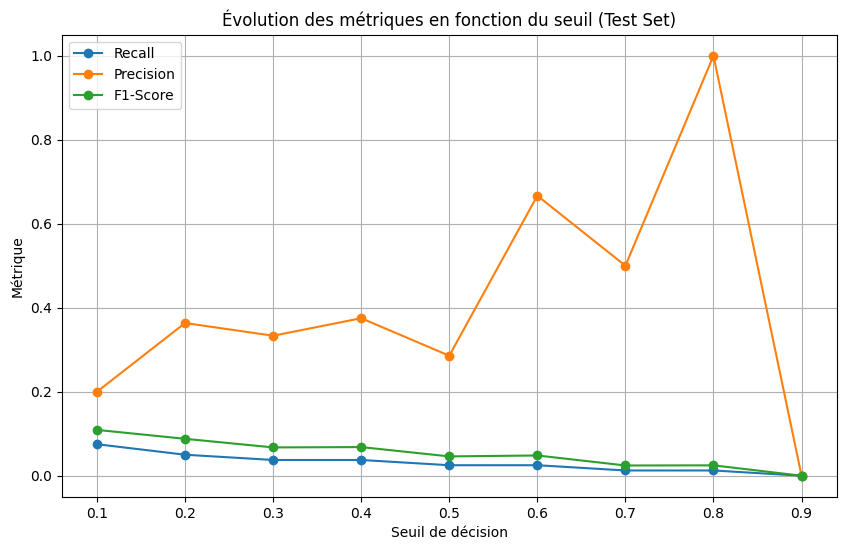

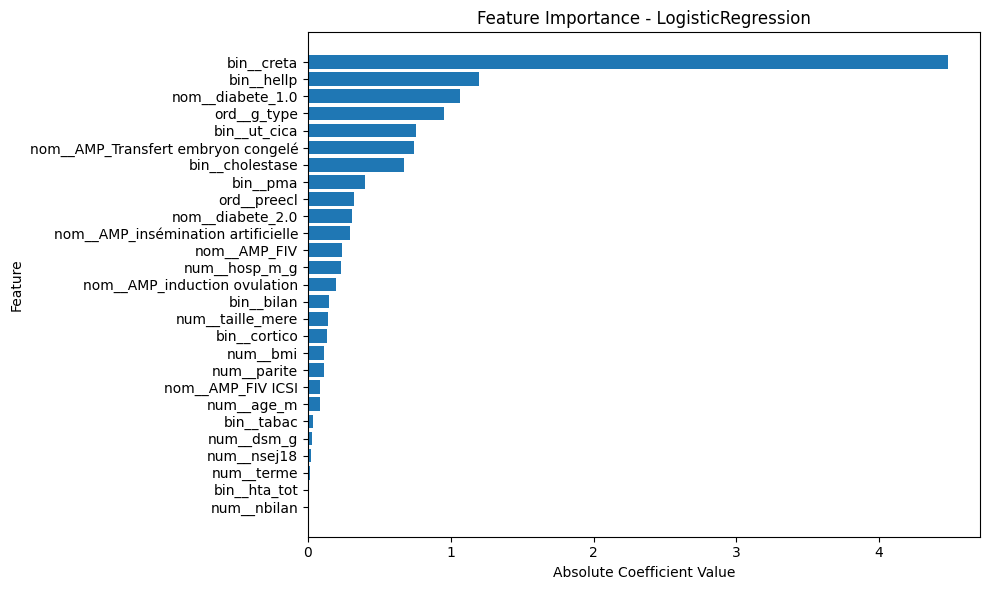

In [83]:
model = LogisticRegression(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

log_reg_baseline=pipeline.fit(X_train,y_train)

# Évaluation du modèle baseline
baseline_results = evaluate_model(log_reg_baseline, X_train, X_test, y_train, y_test, 
                                experiment_name="LR_prediction", run_name="LR_baseline",use_mlflow=False)
